In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from riskfolio.Portfolio import Portfolio
import pandas_market_calendars as mcal
from datetime import datetime, timedelta
from pathlib import Path
import seaborn as sns

LOADING DATA

In [1]:
def load_price_data():
    filepath = os.path.join('D:\\Quant\\Data', f"master_stock_data.csv")
    df = pd.read_csv(filepath, parse_dates=['Date'])
    
    # Pivot long format to wide: index = Date, columns = Symbol, values = Close
    prices = df.pivot(index='Date', columns='Symbol', values='Close')
    prices = prices.sort_index()
    columns= prices.columns.unique()
    columns = columns[:20]
    prices = prices[columns]
    prices = prices[prices.index > '2023-01-01']# Limit to first 20 columns for performance
    return prices

BASE STRATEGY 

In [2]:
def ewma_momentum_signals(price_df, span=60, threshold=0.001, min_days_above_thresh=15):
    """
    Compute EWMA momentum and generate trade signals based on persistence.

    Args:
        price_df (DataFrame): Price data (dates x tickers).
        span (int): EWMA span.
        threshold (float): Momentum threshold to count as 'positive'.
        min_days_above_thresh (int): Min # of days momentum must be above threshold in lookback window.

    Returns:
        momentum_df (DataFrame): EWMA momentum scores.
        signal_df (DataFrame): Binary trade signals (1 = trade, 0 = ignore).
    """
    log_returns = np.log(price_df / price_df.shift(1))
    momentum_df = log_returns.ewm(span=span, adjust=False).mean().shift(1)

    # Boolean mask where momentum is above threshold
    positive_momentum = (momentum_df > threshold).astype(int)

    # Rolling count of how many times momentum was above threshold
    persistence_count = positive_momentum.rolling(window=span).sum()

    # Signal only if count exceeds minimum required
    signal_df = (persistence_count >= min_days_above_thresh).astype(int)

    return momentum_df, signal_df

def simple_moving_average(price_df, short_window=20, long_window=50):
    """
    Compute simple moving averages and generate trade signals.

    Args:
        price_df (DataFrame): Price data (dates x tickers).
        short_window (int): Short moving average window.
        long_window (int): Long moving average window.

    Returns:
        sma_short (DataFrame): Short moving averages.
        sma_long (DataFrame): Long moving averages.
        signal_df (DataFrame): Binary trade signals (1 = buy, -1 = sell, 0 = hold).
    """
    sma_short = price_df.rolling(window=short_window).mean()
    sma_long = price_df.rolling(window=long_window).mean()

    # Generate signals
    signal_df = pd.DataFrame(index=price_df.index, columns=price_df.columns)
    signal_df[sma_short > sma_long] = 1  # Buy signal
    signal_df[sma_short < sma_long] = -1  # Sell signal
    signal_df.fillna(0, inplace=True)  # Hold signal

    return sma_short, sma_long, signal_df

WEIGHTING PORTFOLIO

In [3]:
def construct_risk_parity_portfolio_riskfolio(price_df, window=60):
    returns = price_df.pct_change().dropna()
    weights_list = []
    dates = []

    for i in range(window, len(returns)):
        ret_window = returns.iloc[i - window:i]

        port = Portfolio(returns=ret_window)
        port.assets_stats(method_mu='hist', method_cov='hist')

        # Risk parity model with classic covariance and min variance risk measure
        w = port.optimization(model='Classic', rm='MV', obj='MinRisk')

        weights_list.append(w.values.flatten())
        dates.append(returns.index[i])

    weights_df = pd.DataFrame(weights_list, index=dates, columns=price_df.columns)
    return weights_df


def construct_kelly_portfolio(price_df, window=60, cap=1.0):
    """
    Construct portfolio using the Kelly Criterion.

    Args:
        price_df (DataFrame): Price data (dates x tickers).
        window (int): Lookback window to estimate mu and sigma.
        cap (float): Max allocation to any asset (after normalization).

    Returns:
        DataFrame: Kelly weights (dates x tickers).
    """
    returns = price_df.pct_change().dropna()
    weights_list = []
    dates = []

    for i in range(window, len(returns)):
        ret_window = returns.iloc[i - window:i]
        mu = ret_window.mean().values  # Expected returns (daily)
        sigma = ret_window.cov().values  # Covariance matrix

        try:
            kelly_weights = np.linalg.solve(sigma, mu)  # w = Σ⁻¹μ
        except np.linalg.LinAlgError:
            kelly_weights = np.zeros(len(mu))

        # Normalize to sum to 1 (or 0 if all zero)
        kelly_weights = np.clip(kelly_weights, 0, cap)
        if kelly_weights.sum() > 0:
            kelly_weights /= kelly_weights.sum()

        weights_list.append(kelly_weights)
        dates.append(returns.index[i])

    weights_df = pd.DataFrame(weights_list, index=dates, columns=price_df.columns)
    return weights_df

BACKTESTING

In [4]:
def backtest_portfolio_holding_period(weights_df, price_df, holding_period=60):
    """
    Backtest portfolio returns with a fixed holding period.

    Args:
        weights_df (DataFrame): Daily portfolio weights (dates x tickers).
        price_df (DataFrame): Daily price data (dates x tickers).
        holding_period (int): Holding period in days.

    Returns:
        Series: Portfolio returns aligned with price_df.
    """
    returns = price_df.pct_change().shift(-1).fillna(0)
    weights_df = weights_df.shift(1).reindex_like(returns).fillna(0)

    portfolio_returns = pd.Series(0.0, index=returns.index)

    # Rebalance every `holding_period` days
    rebalance_dates = weights_df.index[::holding_period]

    for rebalance_date in rebalance_dates:
        if rebalance_date not in weights_df.index:
            continue

        w = weights_df.loc[rebalance_date].values
        start_idx = returns.index.get_loc(rebalance_date)

        # Determine end of holding period
        end_idx = min(start_idx + holding_period, len(returns))
        window = returns.iloc[start_idx:end_idx]

        # Apply same weights across holding period
        pnl = window @ w
        portfolio_returns.iloc[start_idx:end_idx] = pnl.values

    return portfolio_returns

METRICS LOGGING

In [5]:
def performance_metrics(returns, freq=252):
    cumulative = (1 + returns).prod() - 1
    annualized = (1 + cumulative)**(freq / len(returns)) - 1
    volatility = returns.std() * np.sqrt(freq)
    sharpe = annualized / volatility
    max_drawdown = (returns.cumsum() - returns.cumsum().cummax()).min()

    return {
        "Cumulative Return": cumulative,
        "Annualized Return": annualized,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_drawdown
    }

OTHER FUNCTIONS

In [6]:
def apply_signal_mask(weights_df, signal_df):
    """
    Zero out weights for symbols not in the signal.

    Args:
        weights_df: DataFrame of raw weights (dates x tickers).
        signal_df: Binary DataFrame (dates x tickers), 1 = investable.

    Returns:
        masked_weights_df: Filtered weights with non-signal symbols zeroed.
    """
    # Align signal_df index to weights_df
    signal_df = signal_df.reindex_like(weights_df).fillna(0).astype(int)

    # Element-wise multiplication to apply the mask
    masked_weights_df = weights_df * signal_df

    # Re-normalize weights so each row sums to 1 (or 0 if all-zero)
    row_sums = masked_weights_df.sum(axis=1)
    normalized_weights = masked_weights_df.div(row_sums.replace(0, np.nan), axis=0).fillna(0)

    return normalized_weights

TRADE EXECUTION

In [2]:
def get_trade_entry_exit_dates(begin_new_trading_period=True, holding_period=None, entry_date=None):
    if not begin_new_trading_period:
        return None, None

    nyse = mcal.get_calendar('NYSE')
    today = datetime.today().date()

    # Parse entry_date
    if entry_date:
        if isinstance(entry_date, str):
            entry_date = datetime.strptime(entry_date, "%Y-%m-%d").date()
        elif isinstance(entry_date, datetime):
            entry_date = entry_date.date()
        elif not isinstance(entry_date, datetime.date):
            raise ValueError("entry_date must be a date, datetime, or YYYY-MM-DD string")
    else:
        entry_date = today

    # Get trading schedule
    days_to_add = 90 if holding_period is None else holding_period + 30
    schedule = nyse.schedule(start_date=entry_date, end_date=entry_date + timedelta(days=days_to_add))
    trading_days = list(schedule.index.date)

    # Adjust entry_date to next valid trading day
    next_entry_dates = [d for d in trading_days if d >= entry_date]
    if not next_entry_dates:
        raise ValueError("No valid trading days found after entry_date")
    entry_date = next_entry_dates[0]

    # If holding_period is not given, return only entry date
    if holding_period is None:
        return entry_date, None

    # Calculate exit date
    desired_exit_date = entry_date + timedelta(days=holding_period - 1)
    candidate_exit_days = [d for d in trading_days if entry_date <= d <= desired_exit_date]

    if candidate_exit_days:
        exit_date = candidate_exit_days[-1]
    else:
        exit_date = max([d for d in trading_days if d <= desired_exit_date], default=None)
        if exit_date is None:
            raise ValueError("No valid exit trading day found")

    return entry_date, exit_date

def get_previous_trading_day(date):
    nyse = mcal.get_calendar('NYSE')
    schedule = nyse.schedule(start_date=date - timedelta(days=10), end_date=date)
    trading_days = list(schedule.index.date)
    for d in reversed(trading_days):
        if d < date:
            return pd.to_datetime(d)

def prepare_trade_allocation(entry_date, price_df, weights, capital=100_000):
    """
    Prepare trade allocations for the upcoming entry_date.
    Assumes this is run *after market close* on the day before entry_date.
    
    Args:
        entry_date (date): The date you plan to enter (buy) positions next market open.
        price_df (DataFrame): Price data with Date index and Symbols as columns (daily close).
        filtered_kelly_weights (DataFrame): Weights filtered and normalized by date and symbol.
        capital (float): Total capital to allocate.

    Returns:
        dict: {
            'entry_date': entry_date,
            'allocation_date': allocation_date,  # day before entry_date
            'weights': weights,
            'prices': entry_prices,
            'shares': shares,
            'capital_allocated': invested_capital
        }
    """
    allocation_date = get_previous_trading_day(entry_date)
    
    # Validate dates
    if allocation_date not in weights.index:
        raise ValueError(f"Allocation date {allocation_date} not found in filtered_kelly_weights")

    
    # Get weights from day before entry
    weights = weights.loc[allocation_date]
    weights = weights[weights > 0]  # only positive weights
    
    if weights.sum() == 0:
        raise ValueError(f"No positive weights on allocation date {allocation_date}")
    
    weights /= weights.sum()  # Normalize
    
    # Get prices on entry date (next open prices assumed equal to close previous day for simplicity)
    # You can replace with actual open prices if available
    entry_prices = price_df.loc[allocation_date, weights.index]
    
    # Calculate shares to buy (integer shares)
    shares = (capital * weights / entry_prices).fillna(0).astype(int)
    
    invested_capital = (shares * entry_prices).sum()
    
    data = pd.DataFrame({
        'entry_date': entry_date,
        'allocation_date': allocation_date,
        'shares': shares,
        'symbols': shares.index,
        'capital_allocated': invested_capital
    })
    
    data.to_csv('portfolio_allocation.csv',index=False)
    
    return entry_date, allocation_date, weights,entry_prices,shares,invested_capital


PORTFOLIO PERFORMANCE TRACKING

In [8]:
def track_portfolio_performance(
    price_df,
    entry_date,
    shares,
    invested_capital,
    log_path="portfolio_performance_log.csv",
    overwrite_log=False
):
    """
    Tracks daily portfolio performance from 7 days before entry_date to today.
    Avoids re-logging already tracked dates.

    Args:
        price_df (pd.DataFrame): Price data (index = Date, columns = Symbols).
        entry_date (datetime.date or str): Date when shares were bought.
        shares (pd.Series): Shares bought per symbol (index = symbol).
        invested_capital (float): Total capital spent.
        log_path (str): File path to save performance log.
        overwrite_log (bool): If True, deletes existing log and starts fresh.

    Returns:
        pd.DataFrame: Updated performance log.
    """
    # Ensure datetime handling
    price_df.index = pd.to_datetime(price_df.index)
    entry_date = pd.to_datetime(entry_date).date()
    start_date = entry_date - timedelta(days=20)
    today = datetime.today().date()

    # Filter trading dates
    trading_dates = sorted([d for d in price_df.index.date if start_date <= d <= today])
    if not trading_dates:
        raise ValueError("No valid trading dates in the specified range.")

    # Slice price data for relevant dates and symbols
    symbols = shares.index
    price_slice = price_df.loc[price_df.index.date >= start_date, symbols]
    price_slice = price_slice[price_slice.index.date <= today]

    portfolio_values = (price_slice * shares).sum(axis=1)

    daily_profit = portfolio_values.diff().fillna(0)  # $ change vs previous day
    cumulative_profit = portfolio_values - invested_capital  # $ total profit since entry

    daily_return = portfolio_values.pct_change().fillna(0)  # % change vs previous day
    cumulative_return = cumulative_profit / invested_capital  # total % return since entry
    
    performance_df = pd.DataFrame({
        "date": portfolio_values.index.date,
        "portfolio_value": portfolio_values.values,
        "daily_profit": daily_profit.values,
        "cumulative_profit": cumulative_profit.values,
        "daily_return": daily_return.values,
        "cumulative_return": cumulative_return.values
    })

    # Handle logging
    if overwrite_log and Path(log_path).exists():
        Path(log_path).unlink()

    if Path(log_path).exists():
        old_df = pd.read_csv(log_path, parse_dates=["date"])
        old_df["date"] = pd.to_datetime(old_df["date"]).dt.date

        # Avoid duplicate dates
        new_df = performance_df[~performance_df["date"].isin(old_df["date"])]
        performance_df = pd.concat([old_df, new_df], ignore_index=True)
        performance_df.sort_values("date", inplace=True)
        print(f"{len(new_df)} new rows logged.")
    else:
        print(f"{len(performance_df)} rows logged (new log).")

    # Save updated log
    performance_df.to_csv(log_path, index=False)
    print(f"Performance log updated. Last date: {performance_df['date'].max()}")
    
    return performance_df

PLOTTING

In [ ]:
def plot_portfolio_performance_with_entry_split(performance_df, entry_date):
    """
    Plot portfolio value over time, using a different color before and after entry_date.

    Args:
        performance_df (pd.DataFrame): DataFrame with 'date', 'portfolio_value', 'return_pct'.
        entry_date (datetime.date or str): Entry date to split the plot.
    """
    # Ensure datetime types
    performance_df['date'] = pd.to_datetime(performance_df['date'])
    entry_date = pd.to_datetime(entry_date)

    # Split data before and after entry
    before_entry = performance_df[performance_df['date'] < entry_date]
    after_entry = performance_df[performance_df['date'] >= entry_date]

    # Plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    # Plot pre-entry in gray
    plt.plot(before_entry['date'], before_entry['cumulative_profit'], color='gray', linestyle='--', label='Before Entry')

    # Plot post-entry in blue
    plt.plot(after_entry['date'], after_entry['cumulative_profit'], color='tab:blue', linewidth=2, label='After Entry')

    plt.axvline(entry_date, color='black', linestyle=':', linewidth=1)
    plt.title("Portfolio Value Over Time")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_rolling_sharpe_ratio(performance_df, window=1):
    """
    Plot rolling Sharpe ratio over time.

    Args:
        performance_df (pd.DataFrame): Must contain 'date' and 'daily_return'.
        window (int): Rolling window size in days.
        risk_free_rate_annual (float): Annualized risk-free rate (e.g., 0.05 for 5%).
    """
    # Ensure proper types
    performance_df['date'] = pd.to_datetime(performance_df['date'])
    performance_df = performance_df.sort_values('date')
    

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(performance_df['date'], performance_df['sharpe_ratio'], label='Sharpe', color='tab:green')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"{window}-Day Rolling Sharpe Ratio Over Time")
    plt.xlabel("Date")
    plt.ylabel("Sharpe Ratio")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [157]:
price_df = load_price_data()
kelly_weights = construct_kelly_portfolio(price_df, window=60)
momentum_scores, signals = ewma_momentum_signals(price_df)
filtered_kelly_weights = apply_signal_mask(kelly_weights, signals)
kelly_returns = backtest_portfolio_holding_period(filtered_kelly_weights, price_df, holding_period=20)
metrics = performance_metrics(kelly_returns)

In [159]:
entry_date, exit_date = get_trade_entry_exit_dates(begin_new_trading_period=True)
entry_date, allocation_date, weights,entry_prices,shares,invested_capital = prepare_trade_allocation(entry_date, price_df, filtered_kelly_weights, capital=100000)

In [160]:
performance_df = track_portfolio_performance(
    price_df=price_df,
    entry_date=entry_date,
    shares=shares,
    invested_capital=invested_capital
)

0 new rows logged.
Performance log updated. Last date: 2025-07-07


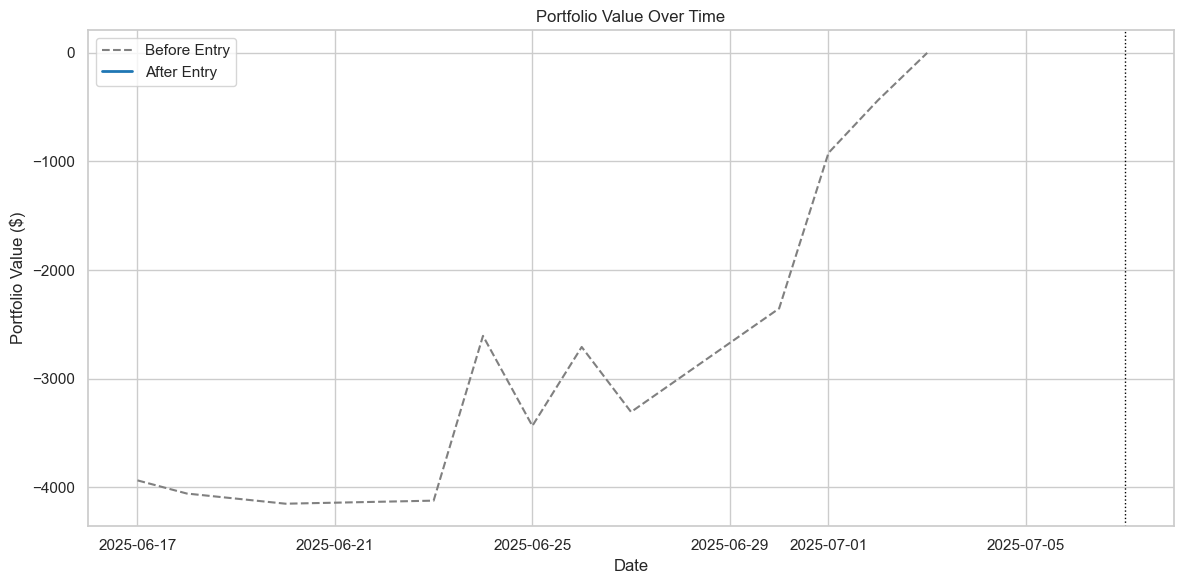

In [161]:
plot_portfolio_performance_with_entry_split(performance_df, entry_date)